In [1]:
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt
import os
import sys
import pandas as pd
from collections import Counter
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import warnings
from Bio import SeqIO, AlignIO, pairwise2, SeqUtils


#from Bio import AlignIO   #, Align
#import shutil

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')

summary_data_dir = base_dir + os.sep + os.path.normpath('/Output/Summary')

#Load dictionary to translate 3 letter aa code to 1 letter aa code
trans_dict = SeqUtils.IUPACData.protein_letters_3to1

In [2]:
# First Feature:  Binding Site
feature='binding_site'
min_feature_size = 5
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep


In [4]:
# Trim Alignment by Structural Feature

#  Note:  Need to make fasta_renamed and cds_align folders before running this
#  This routine makes alignments (stored in feature_subsets/<feature>/fasta_renamed) and cds alignments (stored in feature_subsets/<feature>/cds_aln) for just the specified feature

#Example OG1316_REF_Scer_AF-P19097-F1-model_v2 -- FAS2 as it is an enzyme with a less conserved binding site
#og_ref = 'OG1316_REF_Scer_AF-P19097-F1-model_v2'

feature_sizes = {}


for fasta_file in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/')):
    og_ref = fasta_file.split('.')[0]
    print(og_ref)

    ref = '_'.join(og_ref.split('_')[1:])
     
    
    if ref+'.pkl' in os.listdir(summary_data_dir): 
        #Load Summary data for given og_ref
        og_summary_fname = summary_data_dir + os.sep + ref + '.pkl'
        with open(og_summary_fname, 'rb') as f_in:
                og_summary = pickle.load(f_in)

        #Check to see if the feature exists for that protein
        if 'Binding Site' in set(og_summary['Mapping Colors'].keys()):

            aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
            aln = AlignIO.read(open(aln_fname),'fasta')

            aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_aln/' + og_ref + '.tm.cds.aln.fasta')
            aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')


            #Load alignment and make dictionary to map ref structure coordinates to alignment coordinates

            ref_ind=None
            for (jj, record) in enumerate(aln): 
                if ref == record.id.split('.')[0]:
                    ref_ind = jj

            #Get map for reference sequence from msa index
            ref_seq_from_msa = str(aln[ref_ind,:].seq)
            ref_seq, msa2ref, ref2msa, pair_mapping = dyt.seq_squeeze(ref_seq_from_msa)


            #Get list of indices for the feature   
            feat_inds_ref = []
            for jj, feature_present in enumerate((og_summary['Mapping Colors']['Binding Site']==1)): 
                if feature_present:
                    feat_inds_ref.append(jj)

            feature_size = len(feat_inds_ref)
            feature_sizes[og_ref] = feature_size

            if feature_size>= min_feature_size: 
                feat_inds_msa = []


                for feat_ind in feat_inds_ref: 
                    feat_inds_msa.append(ref2msa[feat_ind])

                    #Verify seq_squeeze is mapping correctly
                    assert (ref_seq[feat_ind] == ref_seq_from_msa[ref2msa[feat_ind]]), "bad mapping to ref from seq_squeeze"

                    #Verify identical sequence in tm_align reference and in Output/Summary data
                    aa_3L_caps = og_summary['Mapping']['Amino Acid'][0,:][feat_ind]
                    aa_3L = aa_3L_caps[0] + aa_3L_caps[1:].lower()
                    trans_dict[aa_3L]
                    assert (ref_seq[feat_ind] == trans_dict[aa_3L]), "Difference in sequence between tm_align alignment and Output/Summary data: " + og_ref + ' ' + str(feat_ind) + ' ' + ref_seq[feat_ind] + ' vs ' + aa3L 

                #Extract Alignment Subsets
                #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
                #Converts alignment to numpy array then converts back to aln object

                aln_temp = aln[:,0:0]
                aln_cds_temp = aln_cds[:,0:0]

                for x in feat_inds_msa:
                    aln_subset = aln_temp[:,:] + aln[:, (x-1):x]
                    aln_temp = aln_subset

                    aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
                    aln_cds_temp = aln_cds_subset

                #Save alignment subset
                aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
                with open(aln_subset_fname_out,'w') as f_out: 
                    for record in aln_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')

                aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                with open(aln_cds_subset_fname_out,'w') as f_out: 
                    for record in aln_cds_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')
            else: 
                print(feature + ' size of ' + str(feature_size) + ' below threshold size of ' + str(min_feature_size))

        else: 
            print('No ' + feature + ' for ' + og_ref)
    
    else: 
        print('No .pkl file for ' + og_ref)

OG2956_REF_Scer_AF-P08456-F1-model_v2
No binding_site for OG2956_REF_Scer_AF-P08456-F1-model_v2
OG3104_REF_Scer_AF-P53954-F1-model_v2
No binding_site for OG3104_REF_Scer_AF-P53954-F1-model_v2
OG3242_REF_Scer_AF-P38179-F1-model_v2
No binding_site for OG3242_REF_Scer_AF-P38179-F1-model_v2
OG1473_REF_Scer_AF-P53204-F1-model_v2
No binding_site for OG1473_REF_Scer_AF-P53204-F1-model_v2
OG1030_REF_Scer_AF-P37291-F1-model_v2
No binding_site for OG1030_REF_Scer_AF-P37291-F1-model_v2
OG2112_REF_Scer_AF-P33421-F1-model_v2
No binding_site for OG2112_REF_Scer_AF-P33421-F1-model_v2
OG2028_REF_Scer_AF-P00899-F1-model_v2
No binding_site for OG2028_REF_Scer_AF-P00899-F1-model_v2
OG5722_geotrichum_candidum__OG5722__43_1771
No .pkl file for OG5722_geotrichum_candidum__OG5722__43_1771
OG2056_REF_Scer_AF-P20051-F1-model_v2
No binding_site for OG2056_REF_Scer_AF-P20051-F1-model_v2
OG3043_REF_Scer_AF-P04161-F1-model_v2
No binding_site for OG3043_REF_Scer_AF-P04161-F1-model_v2
OG3581_REF_Scer_AF-P41835-F1-mo

In [17]:
feature_sizes = {'OG1004_REF_Scer_AF-P15938-F1-model_v2': 45,
 'OG1004_REF_Scer_AF-P40459-F1-model_v2': 18,
 'OG1054_REF_Scer_AF-P16861-F1-model_v2': 31,
 'OG1055_REF_Scer_AF-P52910-F1-model_v2': 22,
 'OG1056_REF_Scer_AF-P21954-F1-model_v2': 43,
 'OG1060_REF_Scer_AF-P06169-F1-model_v2': 56,
 'OG1060_REF_Scer_AF-P50873-F1-model_v2': 131,
 'OG1070_REF_Scer_AF-P21524-F1-model_v2': 89,
 'OG1112_REF_Scer_AF-P23254-F1-model_v2': 39,
 'OG1145_REF_Scer_AF-P00358-F1-model_v2': 37,
 'OG1180_REF_Scer_AF-P41903-F1-model_v2': 8,
 'OG1193_REF_Scer_AF-P00924-F1-model_v2': 38,
 'OG1208_REF_Scer_AF-P04806-F1-model_v2': 15,
 'OG1266_REF_Scer_AF-P23337-F1-model_v2': 92,
 'OG1299_REF_Scer_AF-P00549-F1-model_v2': 41,
 'OG1310_REF_Scer_AF-P15202-F1-model_v2': 34,
 'OG1316_REF_Scer_AF-P19097-F1-model_v2': 95,
 'OG1364_REF_Scer_AF-P27796-F1-model_v2': 26,
 'OG1365_REF_Scer_AF-P29509-F1-model_v2': 69,
 'OG1377_REF_Scer_AF-P53090-F1-model_v2': 28,
 'OG1388_REF_Scer_AF-P07342-F1-model_v2': 101,
 'OG1414_REF_Scer_AF-P06700-F1-model_v2': 54,
 'OG1424_REF_Scer_AF-P00560-F1-model_v2': 74,
 'OG1451_REF_Scer_AF-P38998-F1-model_v2': 45,
 'OG1463_REF_Scer_AF-P07149-F1-model_v2': 33,
 'OG1487_REF_Scer_AF-P09938-F1-model_v2': 7,
 'OG1488_REF_Scer_AF-P38720-F1-model_v2': 18,
 'OG1537_REF_Scer_AF-P32288-F1-model_v2': 14,
 'OG1567_REF_Scer_AF-P17695-F1-model_v2': 18,
 'OG1603_REF_Scer_AF-P16120-F1-model_v2': 20,
 'OG1603_REF_Scer_AF-P25632-F1-model_v2': 3,
 'OG1629_REF_Scer_AF-P09624-F1-model_v2': 69,
 'OG1630_REF_Scer_AF-P50264-F1-model_v2': 77,
 'OG1631_REF_Scer_AF-P22217-F1-model_v2': 13,
 'OG1650_REF_Scer_AF-P23542-F1-model_v2': 28,
 'OG1667_REF_Scer_AF-P15019-F1-model_v2': 91,
 'OG1674_REF_Scer_AF-P13298-F1-model_v2': 23,
 'OG1684_REF_Scer_AF-P41921-F1-model_v2': 100,
 'OG1767_REF_Scer_AF-P05373-F1-model_v2': 37,
 'OG1786_REF_Scer_AF-P28241-F1-model_v2': 5,
 'OG1807_REF_Scer_AF-Q05871-F1-model_v2': 60,
 'OG1810_REF_Scer_AF-P31116-F1-model_v2': 37,
 'OG1822_REF_Scer_AF-P43616-F1-model_v2': 9,
 'OG1835_REF_Scer_AF-P17505-F1-model_v2': 6,
 'OG1933_REF_Scer_AF-P40545-F1-model_v2': 28,
 'OG1975_REF_Scer_AF-P15454-F1-model_v2': 8,
 'OG1979_REF_Scer_AF-P00445-F1-model_v2': 16,
 'OG2006_REF_Scer_AF-P07257-F1-model_v2': 0,
 'OG2031_REF_Scer_AF-Q08220-F1-model_v2': 43,
 'OG2074_REF_Scer_AF-Q02046-F1-model_v2': 21,
 'OG2186_REF_Scer_AF-P32477-F1-model_v2': 67,
 'OG2197_REF_Scer_AF-P00942-F1-model_v2': 45,
 'OG2248_REF_Scer_AF-P07143-F1-model_v2': 68,
 'OG2356_REF_Scer_AF-P33312-F1-model_v2': 31,
 'OG2357_REF_Scer_AF-P33734-F1-model_v2': 33,
 'OG2365_REF_Scer_AF-P08536-F1-model_v2': 116,
 'OG2380_REF_Scer_AF-P53848-F1-model_v2': 36,
 'OG2453_REF_Scer_AF-P27616-F1-model_v2': 81,
 'OG2537_REF_Scer_AF-P11353-F1-model_v2': 9,
 'OG2573_REF_Scer_AF-P38075-F1-model_v2': 24,
 'OG2654_REF_Scer_AF-P00572-F1-model_v2': 31,
 'OG2677_REF_Scer_AF-P28834-F1-model_v2': 24,
 'OG2740_REF_Scer_AF-P07170-F1-model_v2': 53,
 'OG2765_REF_Scer_AF-Q3E840-F1-model_v2': 11,
 'OG2794_REF_Scer_AF-P00950-F1-model_v2': 21,
 'OG2841_REF_Scer_AF-P06738-F1-model_v2': 19,
 'OG2845_REF_Scer_AF-P43577-F1-model_v2': 31,
 'OG2871_REF_Scer_AF-P18408-F1-model_v2': 29,
 'OG2906_REF_Scer_AF-P32178-F1-model_v2': 15,
 'OG2960_REF_Scer_AF-P16622-F1-model_v2': 4,
 'OG3001_REF_Scer_AF-P15807-F1-model_v2': 23,
 'OG3074_REF_Scer_AF-P38913-F1-model_v2': 27,
 'OG3114_REF_Scer_AF-P35202-F1-model_v2': 13,
 'OG3185_REF_Scer_AF-P00447-F1-model_v2': 9,
 'OG3208_REF_Scer_AF-P00128-F1-model_v2': 3,
 'OG3214_REF_Scer_AF-P11986-F1-model_v2': 56,
 'OG3241_REF_Scer_AF-P40363-F1-model_v2': 4,
 'OG3319_REF_Scer_AF-P32626-F1-model_v2': 23,
 'OG3336_REF_Scer_AF-P43567-F1-model_v2': 19,
 'OG3394_REF_Scer_AF-Q03266-F1-model_v2': 21,
 'OG3488_REF_Scer_AF-P53184-F1-model_v2': 13,
 'OG3505_REF_Scer_AF-P04037-F1-model_v2': 11,
 'OG3509_REF_Scer_AF-P43619-F1-model_v2': 25,
 'OG3575_REF_Scer_AF-P08067-F1-model_v2': 30,
 'OG3679_REF_Scer_AF-Q12051-F1-model_v2': 47,
 'OG3702_REF_Scer_AF-P03962-F1-model_v2': 29,
 'OG3767_REF_Scer_AF-P39683-F1-model_v2': 0,
 'OG3935_REF_Scer_AF-P38169-F1-model_v2': 41,
 'OG3978_REF_Scer_AF-P31373-F1-model_v2': 20,
 'OG3994_REF_Scer_AF-P04397-F1-model_v2': 67,
 'OG4004_REF_Scer_AF-Q12178-F1-model_v2': 25,
 'OG4010_REF_Scer_AF-P50861-F1-model_v2': 27,
 'OG4102_REF_Scer_AF-P47096-F1-model_v2': 13,
 'OG4150_REF_Scer_AF-P07256-F1-model_v2': 9,
 'OG4231_REF_Scer_AF-P04385-F1-model_v2': 43,
 'OG4250_REF_Scer_AF-P35731-F1-model_v2': 43,
 'OG4312_REF_Scer_AF-P38115-F1-model_v2': 33,
 'OG4312_REF_Scer_AF-P38280-F1-model_v2': 26,
 'OG4352_REF_Scer_AF-P00127-F1-model_v2': 17,
 'OG4360_REF_Scer_AF-P08525-F1-model_v2': 7,
 'OG4396_REF_Scer_AF-Q06549-F1-model_v2': 6,
 'OG4398_REF_Scer_AF-Q04178-F1-model_v2': 31,
 'OG4463_REF_Scer_AF-Q04066-F1-model_v2': 13,
 'OG4665_REF_Scer_AF-P32449-F1-model_v2': 48,
 'OG4744_REF_Scer_AF-P22289-F1-model_v2': 12,
 'OG5096_REF_Scer_AF-P42883-F1-model_v2': 0,
 'OG5490_REF_Scer_AF-P32340-F1-model_v2': 138}

In [157]:
set(og_summary['Mapping Colors'].keys())

{'Color keys Amino Acid',
 'Color keys Amino Acid Type',
 'Color keys Amino Acid Type reduced',
 'Color keys Amino Acid reduced',
 'Color keys DSSP',
 'Color keys DSSP reduced',
 'Colormap Amino Acid',
 'Colormap Amino Acid Type',
 'Colormap Amino Acid Type reduced',
 'Colormap Amino Acid reduced',
 'Colormap DSSP',
 'Colormap DSSP reduced',
 'Colormap No Mutations',
 'Colormap No Type Mutations',
 'Colormap SASA',
 'Colormap pLDDT',
 'Mapping Amino Acid',
 'Mapping Amino Acid Type',
 'Mapping Amino Acid Type reduced',
 'Mapping Amino Acid reduced',
 'Mapping DSSP',
 'Mapping DSSP reduced',
 'No Mutations',
 'No Type Mutations'}

In [6]:
)
og_list

['OG5490_REF_Scer_AF-P32340-F1-model_v2',
 'OG4744_REF_Scer_AF-P22289-F1-model_v2',
 'OG4665_REF_Scer_AF-P32449-F1-model_v2',
 'OG4463_REF_Scer_AF-Q04066-F1-model_v2',
 'OG4398_REF_Scer_AF-Q04178-F1-model_v2',
 'OG4396_REF_Scer_AF-Q06549-F1-model_v2',
 'OG4360_REF_Scer_AF-P08525-F1-model_v2',
 'OG4352_REF_Scer_AF-P00127-F1-model_v2',
 'OG4312_REF_Scer_AF-P38280-F1-model_v2',
 'OG4312_REF_Scer_AF-P38115-F1-model_v2',
 'OG4250_REF_Scer_AF-P35731-F1-model_v2',
 'OG4231_REF_Scer_AF-P04385-F1-model_v2',
 'OG4150_REF_Scer_AF-P07256-F1-model_v2',
 'OG4102_REF_Scer_AF-P47096-F1-model_v2',
 'OG4010_REF_Scer_AF-P50861-F1-model_v2',
 'OG4004_REF_Scer_AF-Q12178-F1-model_v2',
 'OG3994_REF_Scer_AF-P04397-F1-model_v2',
 'OG3978_REF_Scer_AF-P31373-F1-model_v2',
 'OG3935_REF_Scer_AF-P38169-F1-model_v2',
 'OG3702_REF_Scer_AF-P03962-F1-model_v2',
 'OG3679_REF_Scer_AF-Q12051-F1-model_v2',
 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
 'OG3509_REF_Scer_AF-P43619-F1-model_v2',
 'OG3505_REF_Scer_AF-P04037-F1-mod

In [14]:
#Extract DN/DS values from M0 calculations

m0_base =  base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/binding_site') + os.sep


og_list = []
og_ref_list = []
m0_data_out = {}
m0_dir_list = next(os.walk(m0_base))[1]
m0_dir_list.remove('old')

for og_ref in m0_dir_list:    #next(os.walk(m0_base))[0] gets just directories - https://stackoverflow.com/questions/141291/how-to-list-only-top-level-directories-in-python
    #for og_ref in tm_align_post_trim_filter_list:
    #og_ref = 'OG1299_REF_Scer_AF-P00549-F1-model_v2'
    og = og_ref.split('_')[0]
    print(og_ref)
    og_ref_list.append(og_ref)
    og_list.append(og)
    #print(og_ref)
    m0_dir = m0_base + og_ref + os.sep
    output_file = m0_dir + 'm0.csv'
    paml_gene_dn_ds_file = m0_dir +  'm0.out'
    
    tree_length = None
    kappa = None
    dn_ds = None
    tree_length_dN = None
    tree_length_dS=None
    convergence_issue = None

    with open(paml_gene_dn_ds_file, 'r') as m0_out_data: 
            
        for line in m0_out_data:
            if 'TREE #' in line: 
                line = next(m0_out_data)
                convergence_issue = False
                if 'check convergence..' in line:
                    print('convergence issue in ' + og_ref)
                    convergence_issue = True              
                break
        
        for line in m0_out_data:
            if 'tree length =' in line:
                tree_length = float(line.split('=')[1].strip())
                break

        for line in m0_out_data:
            if 'kappa' in line: 
                kappa = float(line.split('=')[1].strip())
                break

        for line in m0_out_data:
            if 'omega' in line: 
                dN_dS = float(line.split('=')[1].strip())
                break

        for line in m0_out_data:
            if 'tree length for dN:' in line: 
                tree_length_dN = float(line.split(':')[1].strip())
                break

        for line in m0_out_data:
            if 'tree length for dS:' in line: 
                tree_length_dS = float(line.split(':')[1].strip())
                break
    
    if tree_length==None:
        print('tree_length not found for ' + og_ref)
    m0_data_out[og_ref] = (og, tree_length, kappa, dN_dS, tree_length_dN, tree_length_dS, convergence_issue)
    


    
dnds_m0_binding_site = pd.DataFrame.from_dict(m0_data_out, orient='index', columns = ['og', 'tree_length', 'kappa', 'dN_dS_struct', 'tree_length_dN', 'tree_length_dS', 'convergence_issue'])

dnds_m0_binding_site.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/binding_site/m0_binding_site.csv'))


OG5490_REF_Scer_AF-P32340-F1-model_v2
OG4744_REF_Scer_AF-P22289-F1-model_v2
OG4665_REF_Scer_AF-P32449-F1-model_v2
OG4463_REF_Scer_AF-Q04066-F1-model_v2
tree_length not found for OG4463_REF_Scer_AF-Q04066-F1-model_v2
OG4398_REF_Scer_AF-Q04178-F1-model_v2
OG4396_REF_Scer_AF-Q06549-F1-model_v2
convergence issue in OG4396_REF_Scer_AF-Q06549-F1-model_v2
OG4360_REF_Scer_AF-P08525-F1-model_v2
tree_length not found for OG4360_REF_Scer_AF-P08525-F1-model_v2
OG4352_REF_Scer_AF-P00127-F1-model_v2
tree_length not found for OG4352_REF_Scer_AF-P00127-F1-model_v2
OG4312_REF_Scer_AF-P38280-F1-model_v2
tree_length not found for OG4312_REF_Scer_AF-P38280-F1-model_v2
OG4312_REF_Scer_AF-P38115-F1-model_v2
OG4250_REF_Scer_AF-P35731-F1-model_v2
OG4231_REF_Scer_AF-P04385-F1-model_v2
tree_length not found for OG4231_REF_Scer_AF-P04385-F1-model_v2
OG4150_REF_Scer_AF-P07256-F1-model_v2
tree_length not found for OG4150_REF_Scer_AF-P07256-F1-model_v2
OG4102_REF_Scer_AF-P47096-F1-model_v2
tree_length not found for

In [3]:
m0_data_df

NameError: name 'm0_data_df' is not defined

## Compare M0 between active site and whole protein

In [5]:
#Load M0 Data
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'), index_col = 0 )
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)

dnds_m0_binding_site = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/binding_site/m0_binding_site.csv'), index_col=0)
m0_binding_site_col_rename = {col : col + '_m0-BS' for col in dnds_m0_binding_site.columns}
dnds_m0_binding_site_for_merge = dnds_m0_binding_site.rename(columns = m0_binding_site_col_rename)

dnds_struct_data = dnds_m0_binding_site_for_merge.merge(dnds_m0_for_merge, how='outer', left_index=True, right_index=True)

In [20]:
binding_site_size =[]

for og_ref in dnds_struct_data.index: 
    if og_ref in feature_sizes.keys(): 
        binding_site_size.append(feature_sizes[og_ref])
    else: 
        binding_site_size.append(None)

In [21]:
binding_site_size

[45,
 18,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 31,
 22,
 43,
 56,
 131,
 89,
 None,
 None,
 None,
 None,
 None,
 39,
 None,
 None,
 None,
 None,
 None,
 None,
 37,
 None,
 None,
 None,
 8,
 38,
 15,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 92,
 None,
 None,
 None,
 None,
 41,
 None,
 None,
 34,
 None,
 95,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 26,
 69,
 28,
 None,
 101,
 None,
 None,
 54,
 None,
 None,
 74,
 None,
 None,
 None,
 None,
 None,
 45,
 None,
 33,
 None,
 None,
 None,
 None,
 7,
 18,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 14,
 None,
 None,
 None,
 18,
 None,
 None,
 None,
 None,
 None,
 None,
 20,
 None,
 None,
 None,
 None,
 69,
 77,
 13,
 None,
 None,
 28,
 None,
 None,
 91,
 None,
 None,
 23,
 None,
 100,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 37,
 None,
 None,
 None,
 5,
 None,
 60,
 37,
 None,
 None,
 None,
 9,
 None,
 6,
 None,
 None,
 None,
 No

In [22]:
dnds_struct_data['BS_size']=binding_site_size

In [14]:
dnds_struct_data.sort_values(by=['dN_dS_struct_m0-BS'], axis = 0, ascending=False)

,og_m0-BS,tree_length_m0-BS,kappa_m0-BS,dN_dS_struct_m0-BS,tree_length_dN_m0-BS,tree_length_dS_m0-BS,convergence_issue_m0-BS,og_m0,tree_length_m0,kappa_m0,dN_dS_struct_m0,tree_length_dN_m0,tree_length_dS_m0,convergence_issue_m0
OG1316_REF_Scer_AF-P19097-F1-model_v2,OG1316,42.478963,0.98684,0.09599,4.5681,47.5880,False,OG1316,49.848760,1.22294,0.06745,3.9082,57.9441,False
OG1630_REF_Scer_AF-P50264-F1-model_v2,OG1630,NaN,NaN,0.08680,NaN,NaN,NaN,OG1630,343.422486,1.28485,0.01624,7.3593,453.0662,True
OG1631_REF_Scer_AF-P22217-F1-model_v2,OG1631,33.575196,1.95861,0.08680,2.7629,31.8324,False,OG1631,45.669783,1.00011,0.09900,4.5710,46.1732,False
OG1377_REF_Scer_AF-P53090-F1-model_v2,OG1377,47.369450,1.59336,0.07472,3.3128,44.3357,False,OG1377,50.357882,1.20606,0.10546,5.5095,52.2421,False
OG1424_REF_Scer_AF-P00560-F1-model_v2,OG1424,19.541996,1.57591,0.07443,1.5299,20.5552,False,OG1424,25.212191,1.44265,0.09583,2.4158,25.2085,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG5118_REF_Scer_AF-P26364-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG5118,36.246153,1.21087,0.06310,2.6902,42.6348,True
OG5327_REF_Scer_AF-P43635-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG5327,39.473313,1.22873,0.04604,2.1753,47.2525,False
OG5404_REF_Scer_AF-P06115-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG5404,26.879982,1.16007,0.06587,2.2665,34.4073,False
OG5441_REF_Scer_AF-P00724-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG5441,34.689558,1.24218,0.11105,4.0976,36.8974,False


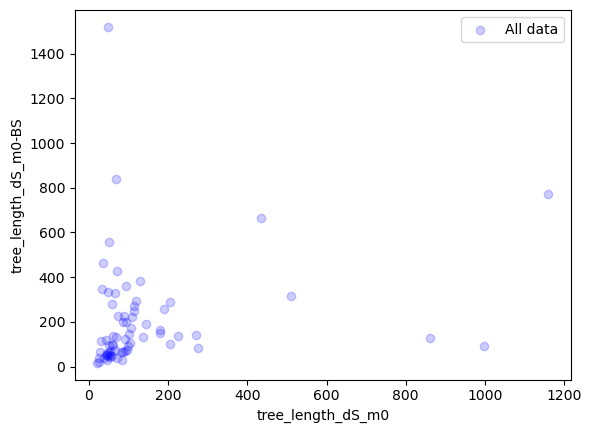

In [29]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

In [33]:
x_value

'tree_length_dS_m0'

In [34]:
from scipy.stats import spearmanr
print(spearmanr(data_to_plot[x_value],data_to_plot[y_value],nan_policy="omit"))

SignificanceResult(statistic=0.3995877390540902, pvalue=0.0007360082601429688)


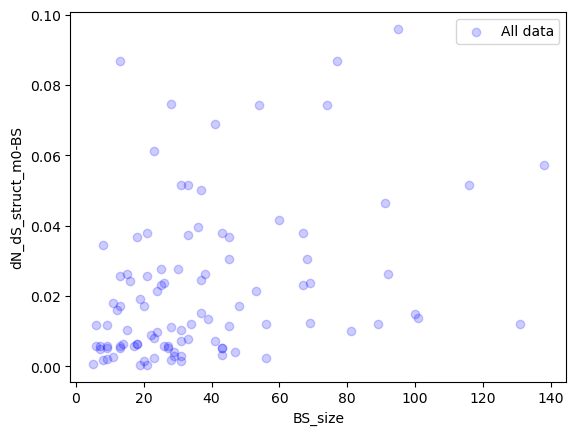

In [23]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'BS_size'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

In [ ]:
#Add in Conservation overall and Conservation of Binding Site

#Extract particular binding sites that look interesting



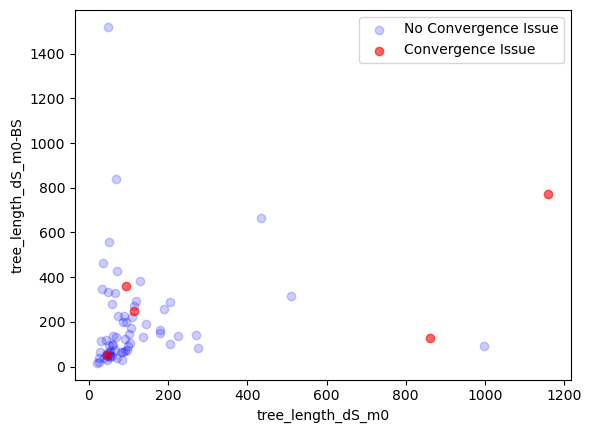

In [28]:
fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')
dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

In [ ]:
#Conservation data is in
scores_mapped = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Mapped.tsv'), index_col = 0)
params_to_plot_mapped = ['Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]', 'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]']
scores_mapped_subset = scores_mapped.loc[:,params_to_plot_mapped]

scores_exp = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Experimental.tsv'), index_col = 0)#
params_to_plot_exp = ['Mean(log2(Abundances)) 10 Sp [EXP]','Median(log2(Abundances)) 10 Sp [EXP]','Std(log2(Abundances)) 10 Sp [EXP]','1k_Mean_log2_Abundances [EXP]']
scores_exp_subset = scores_exp.loc[:,params_to_plot_exp]

scores_data = scores_mapped_subset.merge(scores_exp_subset, how = 'outer', left_index=True, right_index=True)

#Load my YN00 Data
dnds_yn00 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00.csv'), index_col=0)

#Load M0 Data
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'), index_col = 0 )

#Load Nielsen Lab files 
dnds_nl_with_SCE = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_OG_with_SCE.csv'), index_col=0)
dnds_nl_with_SCE['og'] = [og_label.split('.')[0] for og_label in dnds_nl_with_SCE['OG']]
dnds_nl_with_SCE.drop(columns = 'OG', inplace=True)
dnds_nl_with_SCE.rename(columns= {'dN_dS': 'dN_dS_nielsen_SCE'}, inplace=True)

dnds_nl_03_02 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_03_02.csv'), index_col=0)
dnds_nl_03_02['og'] =  [og_label.split('.')[0] for og_label in dnds_nl_03_02['OG']]
dnds_nl_03_02.drop(columns = 'OG', inplace=True)
dnds_nl_03_02.rename(columns= {'dN_dS': 'dN_dS_nielsen_03_02'}, inplace=True)
                         
#merge structural data with m0 data
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)
dnds_struct_data = dnds_m0_for_merge.merge(scores_data, how='outer', left_index=True, right_index=True)

#merge yn00 data
yn00_col_rename = {col:col +'_yn00' for col in dnds_yn00.columns}
dnds_yn00_for_merge = dnds_yn00.rename(columns = yn00_col_rename)
dnds_struct_data = dnds_struct_data.merge(dnds_yn00_for_merge, how='outer', left_index=True, right_index=True)
dnds_struct_data['og_ref'] = dnds_struct_data.index

#Merge nielsen lab data
dnds_struct_data = dnds_struct_data.merge(dnds_nl_with_SCE, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data = dnds_struct_data.merge(dnds_nl_03_02, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data.set_index('og_ref', inplace=True)
